In [1]:
# ref: https://alexioannides.com/2018/11/07/bayesian-regression-in-pymc3-using-mcmc-variational-inference/

In [2]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
import pandas as pd
filterwarnings('ignore')
sns.set_style('white')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
np.random.seed(23)

def build_toy_dataset(N_points=50, noise_std=0.1):
    x = np.linspace(-3, 3, num=N)
    y = np.cos(x) + np.random.normal(0, noise_std, size=N_points)
    x = x.astype(np.float64).reshape((N_points, 1))
    y = y.astype(np.float64)[:,None]
    return x, y

# simulate a toy dataset of observations with a cosine relationship.
N_points = 100  # number of data points

X_data,y_data = build_toy_dataset(N_points)
print (np.shape(X_data),np.shape(y_data))

(100, 1) (100, 1)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=23)
print (np.shape(X_train), np.shape(y_train))
print (np.shape(X_test), np.shape(y_test))

(80, 1) (80, 1)
(20, 1) (20, 1)


In [5]:
n_hidden = 3

# Initialize random weights between each layer
init_w_1 = np.random.randn(X_train.shape[1], n_hidden).astype(floatX)
init_w_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_w_out = np.random.randn(n_hidden,1).astype(floatX)

init_b_1 = np.random.randn(n_hidden).astype(floatX)
init_b_2 = np.random.randn(n_hidden).astype(floatX)
init_b_out = np.random.randn(1).astype(floatX)

with pm.Model() as neural_network:
    # Trick: Turning inputs and outputs into shared variables 
    # It's still the same thing, but we can later change the values of the shared variable
    # (to switch in the test-data later) and pymc3 will just use the new data.
    # Kind-of like a pointer we can redirect.
    # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
    y_tensor = theano.shared(y_train)
    x_tensor = theano.shared(X_train)

    #PRIOR
    # Weights and biases from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                             shape=(X_train.shape[1], n_hidden),
                             testval=init_w_1)
    
    bias_in_1 = pm.Normal('b_in_1', 0, sigma=1,
                             shape=(n_hidden),
                             testval=init_b_1)

    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                            shape=(n_hidden, n_hidden),
                            testval=init_w_2)
  
    bias_1_2 = pm.Normal('b_1_2', 0, sigma=1,
                             shape=(n_hidden),
                             testval=init_b_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                              shape=(n_hidden,1),
                              testval=init_w_out)

    bias_2_out = pm.Normal('b_2_out', 0, sigma=1,
                             shape=(1),
                             testval=init_b_out)
        
    # Build neural-network using activation function
    act_1 = pm.math.tanh(pm.math.dot(x_tensor,
                                     weights_in_1)+bias_in_1)
    act_2 = pm.math.tanh(pm.math.dot(act_1,
                                     weights_1_2)+bias_1_2)
    act_out = pm.math.dot(act_2,weights_2_out)+bias_2_out

    #  LIKELIHOOD
    out = pm.Normal('out', mu=act_out, sigma=0.1, observed=y_tensor)


In [6]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [7]:
# with neural_network:
#     approx = pm.fit(n=60000, method=pm.ADVI())

In [8]:
# We use the more_replacements key-word argument to swap-out the original Theano tensors with the batched versions defined above.
map_tensor_batch = {y_tensor: pm.Minibatch(y_train, 50),
                    x_tensor: pm.Minibatch(X_train, 50)}

with neural_network:
    advi_fit = pm.fit(method=pm.ADVI(), n=60000,
                      more_replacements=map_tensor_batch)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 21.745: 100%|██████████| 60000/60000 [00:28<00:00, 2089.66it/s] 
Finished [100%]: Average Loss = 21.693


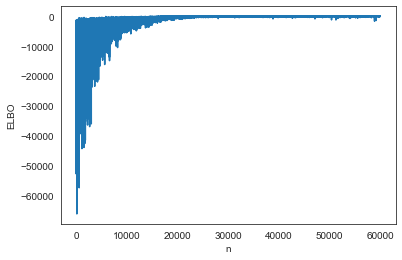

In [18]:
advi_elbo = pd.DataFrame(
    {'ELBO': -(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"w_in_1[0,0]",-0.119,0.336,-0.760,0.504,0.004,0.002,9093.0,9093.0,9078.0,9452.0,NaN
"w_in_1[0,1]",0.810,0.016,0.778,0.839,0.000,0.000,9824.0,9824.0,9826.0,10080.0,NaN
"w_in_1[0,2]",-0.635,0.014,-0.662,-0.610,0.000,0.000,9839.0,9836.0,9837.0,9795.0,NaN
b_in_1[0],0.750,0.556,-0.263,1.802,0.006,0.004,9387.0,9387.0,9376.0,9450.0,NaN
b_in_1[1],1.135,0.025,1.088,1.182,0.000,0.000,9854.0,9854.0,9844.0,9748.0,NaN
b_in_1[2],0.924,0.023,0.881,0.965,0.000,0.000,9929.0,9929.0,9928.0,9598.0,NaN
"w_1_2[0,0]",-0.061,1.021,-1.994,1.826,0.010,0.007,9787.0,9787.0,9788.0,9798.0,NaN
"w_1_2[0,1]",-0.420,0.589,-1.522,0.680,0.006,0.004,10035.0,10035.0,10039.0,9312.0,NaN
"w_1_2[0,2]",-0.006,0.031,-0.062,0.052,0.000,0.000,9751.0,9751.0,9755.0,9593.0,NaN
"w_1_2[1,0]",-0.106,0.997,-2.010,1.727,0.010,0.007,9788.0,9630.0,9790.0,9757.0,NaN


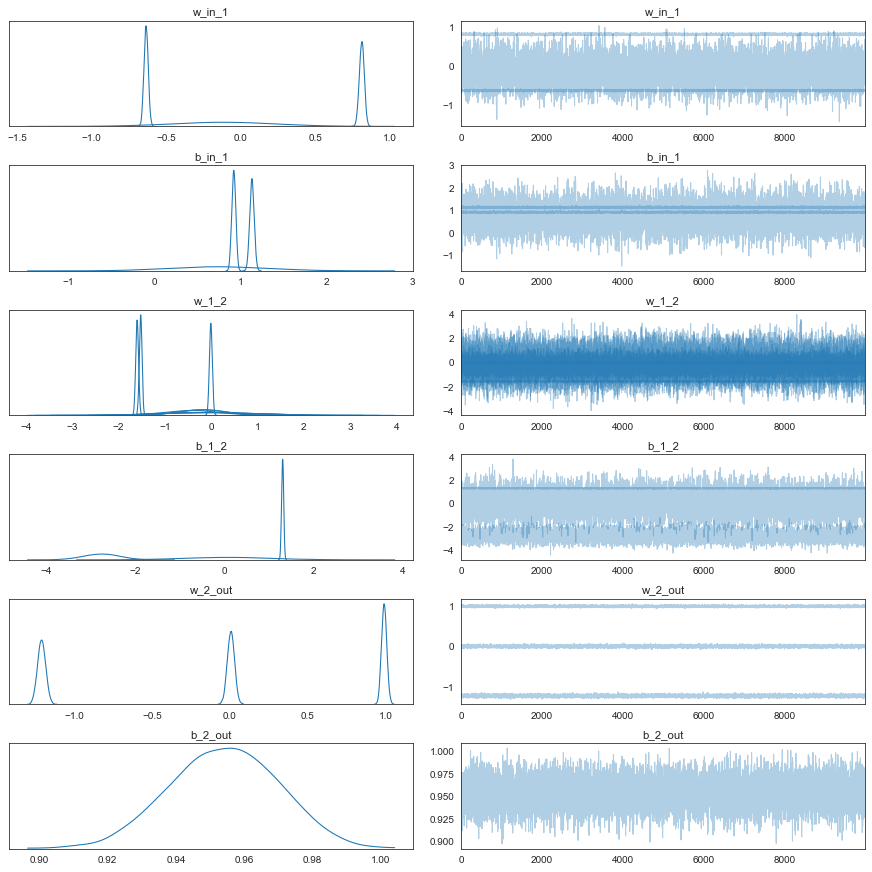

In [10]:
trace = advi_fit.sample(draws=10000)
pm.traceplot(trace)
pm.summary(trace)

## Testing

In [11]:
# testing on whole data for now instead of test data
y_tensor.set_value(y_data)
x_tensor.set_value(X_data)

100%|██████████| 1000/1000 [00:11<00:00, 86.96it/s]


(1000, 100, 1)
        ADVI    actual  error_ADVI
0  -0.944941 -0.923294   -0.021647
1  -0.940803 -0.977046    0.036243
2  -0.929933 -1.043427    0.113494
3  -0.918129 -0.853294   -0.064836
4  -0.905891 -0.857000   -0.048891
..       ...       ...         ...
95 -0.874380 -0.907955    0.033575
96 -0.888580 -1.120482    0.231902
97 -0.909131 -0.919539    0.010408
98 -0.916910 -1.088164    0.171255
99 -0.935562 -0.807655   -0.127907

[100 rows x 3 columns]


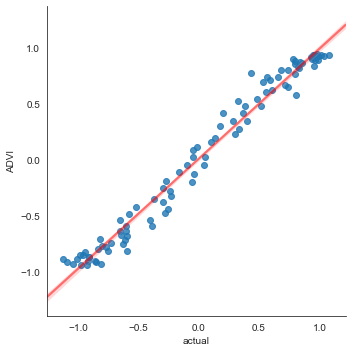

In [55]:
posterior_preds = pm.sample_posterior_predictive(trace, 1000, neural_network)
mean_prediction = np.mean(posterior_preds['out'], axis=0)
stddev_prediction = np.std(posterior_preds['out'], axis=0)
print (posterior_preds['out'].shape)

prediction_data = pd.DataFrame(
    {'ADVI': mean_prediction.flatten(), 
     'actual': y_data.flatten(),
     'error_ADVI': ( mean_prediction - y_data).flatten()})

print (prediction_data)

_ = sns.lmplot(y='ADVI', x='actual', data=prediction_data,
               line_kws={'color': 'red', 'alpha': 0.5})

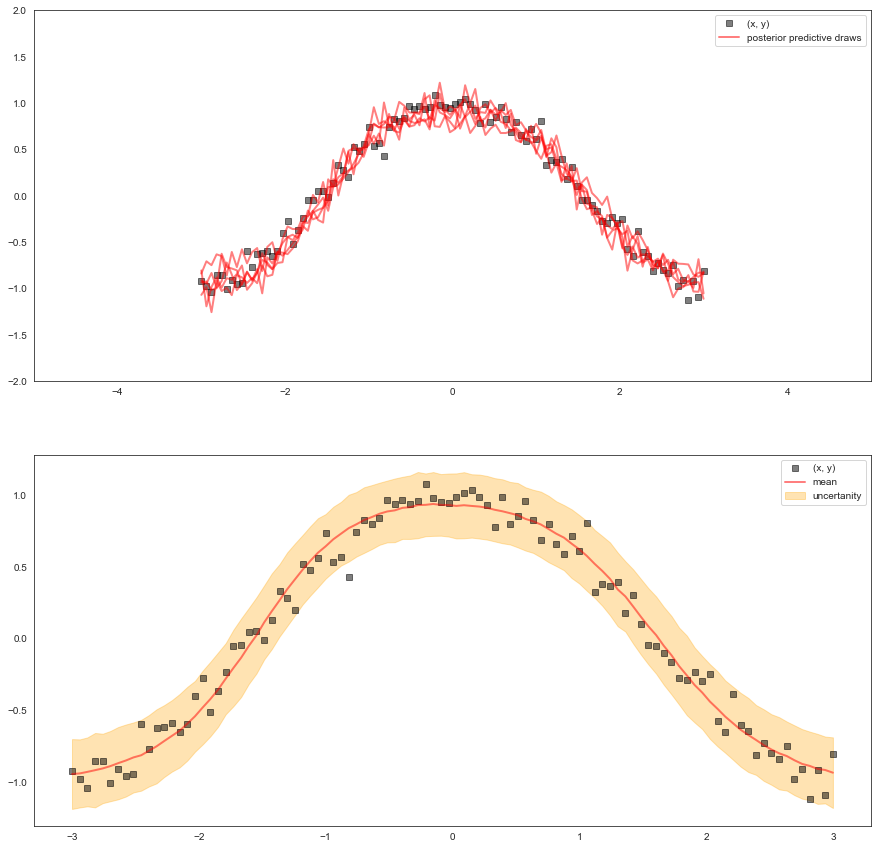

In [56]:
fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(211)
ax1.plot(X_data, y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax1.plot(X_data, posterior_preds['out'][0] ,'r', lw=2, alpha=0.5, label='posterior predictive draws')
ax1.plot(X_data, posterior_preds['out'][1:5].reshape(4,X_data.shape[0]).T, 'r', lw=2, alpha=0.5)
ax1.set_xlim([-5, 5])
ax1.set_ylim([-2, 2])
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(X_data, y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax2.plot(X_data, mean_prediction , 'r', lw=2, alpha=0.5, label='mean')
ax2.fill_between( X_data.ravel(), (mean_prediction-2*stddev_prediction).ravel(), (mean_prediction+2*stddev_prediction).ravel(), alpha = 0.3, color = 'orange',label='uncertanity')
ax2.legend()

plt.show()

In [16]:
RMSE = np.sqrt(np.mean(prediction_data.error_ADVI ** 2))

print(f'RMSE for ADVI predictions = {RMSE:.3f}')

RMSE for ADVI predictions = 0.103


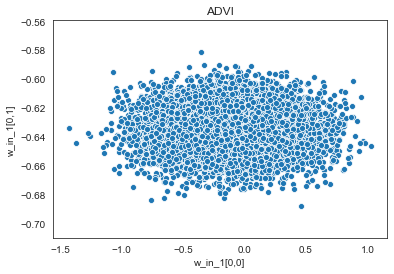

In [17]:
param_samples_ADVI = pd.DataFrame(
    {'w_in_1[0,0]': trace.get_values('w_in_1').reshape(trace.get_values('w_in_1').shape[0],trace.get_values('w_in_1').shape[2])[:,0], 
     'w_in_1[0,1]': trace.get_values('w_in_1').reshape(trace.get_values('w_in_1').shape[0],trace.get_values('w_in_1').shape[2])[:,2]})

_ = sns.scatterplot(x='w_in_1[0,0]', y='w_in_1[0,1]', data=param_samples_ADVI).set_title('ADVI')

In [65]:
print (trace['w_in_1'])

[[[ 0.17931302  0.80579955 -0.63235422]]

 [[-0.36502559  0.82939211 -0.64457974]]

 [[ 0.4046291   0.81085115 -0.64185182]]

 ...

 [[-0.26611811  0.80841085 -0.61971165]]

 [[ 0.32711253  0.81162415 -0.64973534]]

 [[ 0.15147217  0.80386241 -0.64117175]]]
